# Benchmarking Analysis for Multiview Hypothesis Testers

Here, we are interested in analyzing the performance of using multi-view trees in the presence
of two views of data, when one of the datasets has a significantly greater number of dimensions.

For example, in liquid biopsies from cancer patients, we might obtain features describing the
fragment lengths of DNA found, or a description of the fragment ends (e.g. what is the ratio of base-pairs
found at the end). These might have wildly different dimensionalities like 1000 vs 10,000 if we consider
different levels of complexities of each of these biological characteristics.

So we want a hypothesis test that is i) aware of the fact that ``X`` is comprised of two feature-sets, and ii)
is able to handle wildly different dimensionalities in each of the feature-sets with sufficient power
and type-I error rate to provide useful answers to cancer biomarker hypotheses.

The `make_classification` experiment stems from: http://clopinet.com/isabelle/Projects/NIPS2003/Slides/NIPS2003-Datasets.pdf

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit
from sklearn.datasets import (
    make_blobs,
    make_classification,
    make_sparse_spd_matrix,
    make_spd_matrix,
)

from sktree import HonestForestClassifier, RandomForestClassifier, RandomForestRegressor
from sktree.datasets.multiview import make_gaussian_mixture, make_joint_factor_model
from sktree.stats import (
    FeatureImportanceForestClassifier,
    FeatureImportanceForestRegressor,
    PermutationForestRegressor,
)
from sktree.tree import DecisionTreeClassifier, MultiViewDecisionTreeClassifier

seed = 12345
rng = np.random.default_rng(seed)

In [2]:
print("done")

done


In [3]:
max_features = "sqrt"
n_estimators = 500
n_jobs = -1
test_size = 0.2
max_fpr = 0.1

# Simulate data with varying dimensionality

Here, we will implement a function to simulate data with a varying number of dimensions in the second view.

We will implement a simulation that leverages two views stemming from the graphical model:

$(X1 \rightarrow Y \leftarrow X2; X1 \leftrightarrow X2)$

or

$(X1 \rightarrow Y \leftarrow X2)$

where X1 and X2 are two views and Y is the target variable. The bidirected edge between X1 and X2 is just to allow the two views to
be potentially correlated. 

We will also use the package `mvlearn` to simulate a two-view dataset using their `make_gaussian_mixture` function (https://mvlearn.github.io/references/datasets.html#data-simulator). This simulates a ``X`` and a ``y``, and then applies a transformation on ``X``, which produces the second view. This stems from the graphical model:

$(X1 \rightarrow Y \leftarrow X2; X1 \rightarrow X2)$

where X1 is the original dataset and X2 is the transformed dataset.

## Data-generating model with views correlated by a direct effect

In [4]:
n_samples = 500
noise_dims = 80
n_features = 100 - noise_dims
n_features_2 = 10000 - noise_dims

n_repeats = 5

In [10]:
class_probs = [0.75, 0.25]

In [21]:
def make_multiview_dataset(
    n_features=50,
    n_features_2=50,
    noise_dims=50,
    n_samples=100,
    seed=None,
    transform="linear",
    class_probs=None,
):
    fixed_center = rng.standard_normal(size=(n_features,))
    # centers = [
    #     rng.standard_normal(size=(n_features,)),
    #     rng.standard_normal(size=(n_features,)),
    # ]
    centers = [fixed_center, fixed_center]

    covariances = [
        make_spd_matrix(n_dim=n_features, random_state=seed),
        make_spd_matrix(n_dim=n_features, random_state=seed + 123),
    ]

    # covariances = [
    #     make_sparse_spd_matrix(n_features, random_state=seed),
    #     make_sparse_spd_matrix(n_features, random_state=seed + 123),
    # ]

    Xs, y = make_gaussian_mixture(
        centers,
        covariances,
        n_samples=n_samples,
        noise=1.0,
        noise_dims=noise_dims,
        shuffle=True,
        class_probs=class_probs,
    )

    X = np.hstack(
        (Xs[1], Xs[0], rng.standard_normal(size=(n_samples, n_features_2 - n_features)))
    )
    n_features_ends = [
        n_features + noise_dims,
        n_features_2 + n_features + noise_dims * 2,
    ]
    return X, y, n_features_ends

In [17]:
X, y, n_features_ends = make_multiview_dataset(
    n_features=n_features,
    n_features_2=n_features_2,
    noise_dims=noise_dims,
    n_samples=n_samples,
    seed=seed,
    transform="sin",
    class_probs=class_probs,
)
print(X.shape)

est = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=MultiViewDecisionTreeClassifier(
            feature_set_ends=n_features_ends,
            apply_max_features_per_feature_set=True,
        ),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

est_rf = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=DecisionTreeClassifier(),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

# compute the statistic
stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

print(stat, stat_rf)

(500, 100) (500, 100)
(500, 10100)
0.7431578947368421 0.5621052631578948


In [42]:
n_features_2_list = np.linspace(500 - noise_dims, 10_000 - noise_dims, 10, dtype=int)
print(n_features_2_list)

[ 420 1475 2531 3586 4642 5697 6753 7808 8864 9920]


In [43]:
results = defaultdict(list)


for idx in range(n_repeats):
    n_features_begin = 0
    X = np.empty((n_samples, 0))
    y = np.empty((n_samples, 0))

    for n_features_2_ in n_features_2_list:
        _X, _y, n_features_ends = make_multiview_dataset(
            n_features=n_features,
            n_features_2=n_features_2_,
            noise_dims=noise_dims,
            n_samples=n_samples,
            seed=seed + idx + n_features_2_,
            transform="sin",
            class_probs=class_probs,
        )
        # stack features
        # print(X.shape, _X.shape)
        X = _X
        y = _y
        # X = np.hstack((X, _X[:, n_features_begin:]))
        # y = _y.copy()
        # n_features_begin = X.shape[1]

        print(
            "New dataset: ",
            n_features_2_,
            n_features_ends,
            X.shape,
            y.shape,
            n_features_begin,
        )

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)
    # break

New dataset:  420 [100, 600] (500, 600) (500,) 0
New dataset:  1475 [100, 1655] (500, 1655) (500,) 0
New dataset:  2531 [100, 2711] (500, 2711) (500,) 0
New dataset:  3586 [100, 3766] (500, 3766) (500,) 0
New dataset:  4642 [100, 4822] (500, 4822) (500,) 0
New dataset:  5697 [100, 5877] (500, 5877) (500,) 0
New dataset:  6753 [100, 6933] (500, 6933) (500,) 0
New dataset:  7808 [100, 7988] (500, 7988) (500,) 0
New dataset:  8864 [100, 9044] (500, 9044) (500,) 0
New dataset:  9920 [100, 10100] (500, 10100) (500,) 0
New dataset:  420 [100, 600] (500, 600) (500,) 0
New dataset:  1475 [100, 1655] (500, 1655) (500,) 0
New dataset:  2531 [100, 2711] (500, 2711) (500,) 0
New dataset:  3586 [100, 3766] (500, 3766) (500,) 0
New dataset:  4642 [100, 4822] (500, 4822) (500,) 0
New dataset:  5697 [100, 5877] (500, 5877) (500,) 0
New dataset:  6753 [100, 6933] (500, 6933) (500,) 0
New dataset:  7808 [100, 7988] (500, 7988) (500,) 0
New dataset:  8864 [100, 9044] (500, 9044) (500,) 0
New dataset:  99

In [44]:
df = pd.DataFrame(results)

In [45]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features_2", "noise_dims", "n_samples"],
    var_name="model",
    value_name="score",
)

In [46]:
display(df.head())

,n_features_2,noise_dims,n_samples,model,score
0,420,80,500,rf,0.764211
1,1475,80,500,rf,0.769825
2,2531,80,500,rf,0.661754
3,3586,80,500,rf,0.622456
4,4642,80,500,rf,0.664561


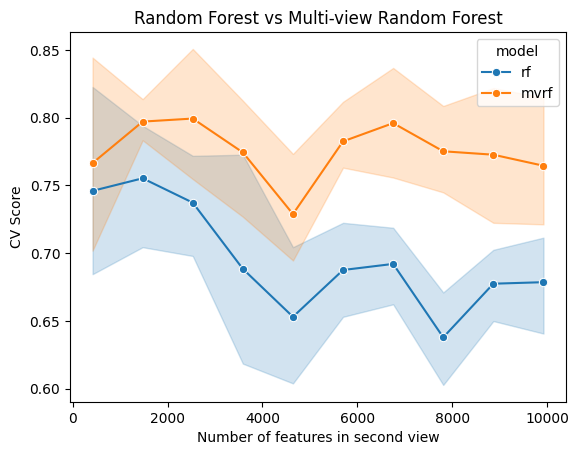

In [47]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

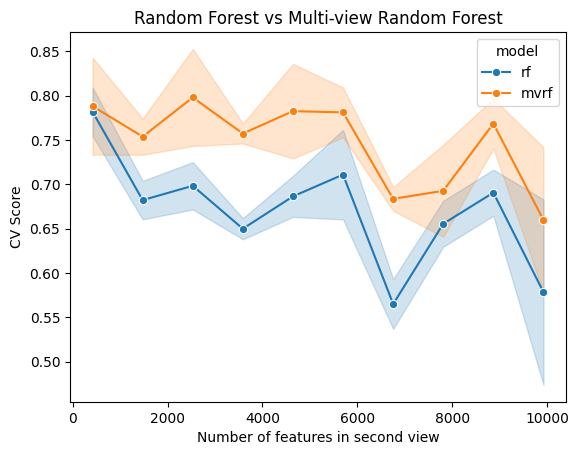

In [17]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

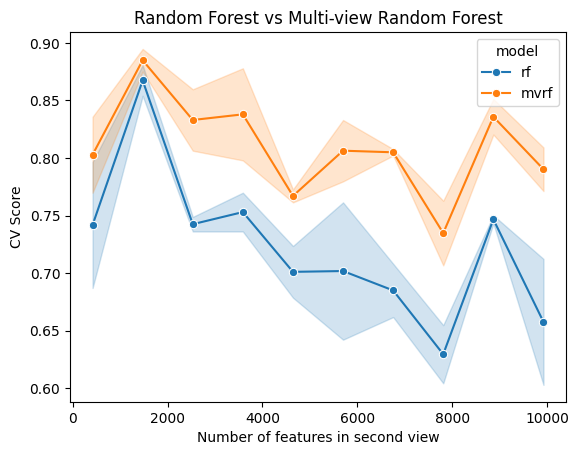

In [140]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

These are some other plots you can generate by playing around with the parameterizations of the data-generating model.

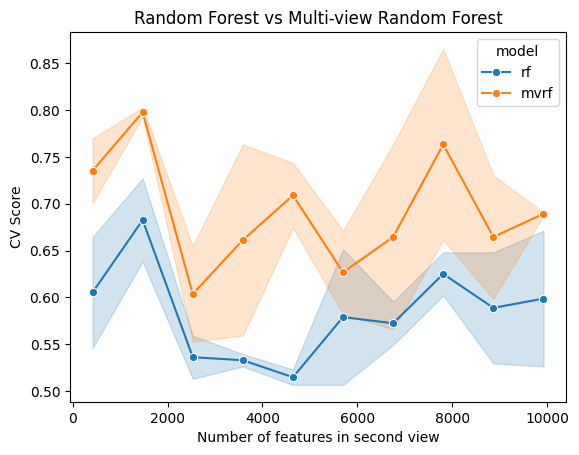

In [127]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

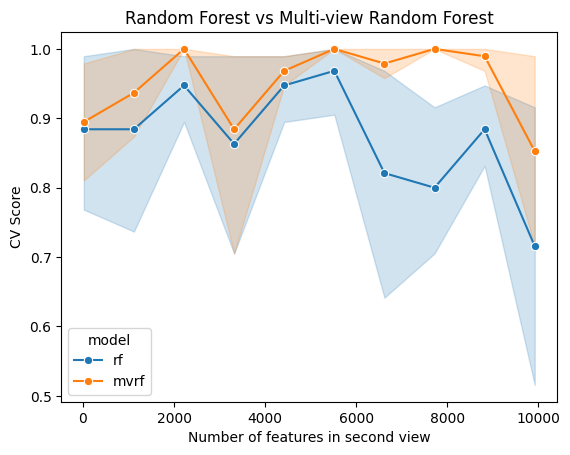

In [39]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

## Data-generating model with correlated views from a latent factor

Here, we proceed by simulating views that are independent, but both predictive of `y`.

In [181]:
def make_multiview_classification(
    n_samples=100,
    n_features_1=100,
    n_features_2=1000,
    noise_dims=20,
    cluster_std_first=2.0,
    cluster_std_second=5.0,
    X0_first=None,
    y0=None,
    X1_first=None,
    y1=None,
    seed=None,
):
    rng = np.random.default_rng(seed=seed)

    if X0_first is None and y0 is None:
        # Create a high-dimensional multiview dataset with a low-dimensional informative
        # subspace in one view of the dataset.
        X0_first, y0 = make_blobs(
            n_samples=n_samples,
            cluster_std=cluster_std_first,
            n_features=n_features_1 - noise_dims,
            center_box=(0, 0),
            random_state=seed,
            centers=1,
        )

        X1_first, y1 = make_blobs(
            n_samples=n_samples,
            cluster_std=cluster_std_second,
            n_features=n_features_2 - noise_dims,
            center_box=(-5, 5),
            random_state=seed + 1,
            centers=1,
        )
    # X0_first = X0_first + rng.standard_normal(size=X0_first.shape) // 10
    # X1_first = X1_first + rng.standard_normal(size=X1_first.shape) // 10
    X0 = np.concatenate(
        [X0_first, rng.standard_normal(size=(n_samples, noise_dims))], axis=1
    )
    X1 = np.concatenate(
        [X1_first, rng.standard_normal(size=(n_samples, noise_dims))], axis=1
    )

    X = np.hstack((X0, X1))

    # y = expit(X0_first[:, :n_features_1//2] + X1_first[:, :n_features_1//2]
    y = rng.binomial(
        n=1, p=expit(X0_first[:, :10].sum(axis=1)), size=n_samples
    ) * rng.binomial(n=1, p=expit(X1_first[:, :10].sum(axis=1)), size=n_samples)
    # y = np.hstack((y0, y1)).T

    # X = X + rng.standard_normal(size=X.shape)

    return X, y

In [268]:
noise_dims = 90
n_estimators = 200
n_features = 100
max_features = "sqrt"
n_features_2 = 1000 - n_features
n_samples = 200

X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features + n_features_2,
    n_informative=20,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    shuffle=True,
    random_state=seed,
)
n_features_ends = [10, X.shape[1]]

# n_features_ends = [n_features, n_features+ n_features_2]
# print(n_features, n_features_2, noise_dims, n_features_ends)
print(X.shape, y.shape, np.sum(y) / n_samples)

(200, 1000) (200,) 0.5


In [266]:
X, y = make_classification(
    n_samples=n_samples,
    n_features=10000,
    n_informative=10,
    n_redundant=5,
    n_repeated=0,
    n_classes=2,
    class_sep=2.0,
    flip_y=0.05,
    shuffle=False,
    random_state=seed,
)
n_features_ends = [20, X.shape[1]]
print(n_features_ends)
print(X.shape, np.sum(y) / n_samples)

est = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=MultiViewDecisionTreeClassifier(
            feature_set_ends=n_features_ends,
            max_features=max_features,
            apply_max_features_per_feature_set=True,
        ),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

est_rf = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=DecisionTreeClassifier(max_features=max_features),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

# compute the statistic
stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

print(stat, stat_rf)

[20, 10000]
(200, 10000) 0.49
0.5526315789473684 0.5394736842105263


In [269]:
print(n_features_2_list)

[ 420 1475 2531 3586 4642 5697 6753 7808 8864 9920]


In [277]:
results = defaultdict(list)

for n_features_2_ in n_features_2_list:
    for idx in range(5):
        X, y = make_classification(
            n_samples=n_samples,
            n_features=n_features_2_ + 20,
            n_informative=10,
            n_redundant=5,
            n_repeated=0,
            n_classes=2,
            class_sep=2.0,
            flip_y=0.05,
            shuffle=False,
            random_state=seed + idx + n_features_2_,
        )
        n_features_ends = [20, X.shape[1]]

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

In [278]:
df = pd.DataFrame(results)

In [279]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features_2", "noise_dims", "n_samples"],
    var_name="model",
    value_name="score",
)

In [280]:
display(df.head())

,n_features_2,noise_dims,n_samples,model,score
0,420,90,200,rf,0.592105
1,420,90,200,rf,0.725630
2,420,90,200,rf,0.986842
3,420,90,200,rf,0.799499
4,420,90,200,rf,0.618421


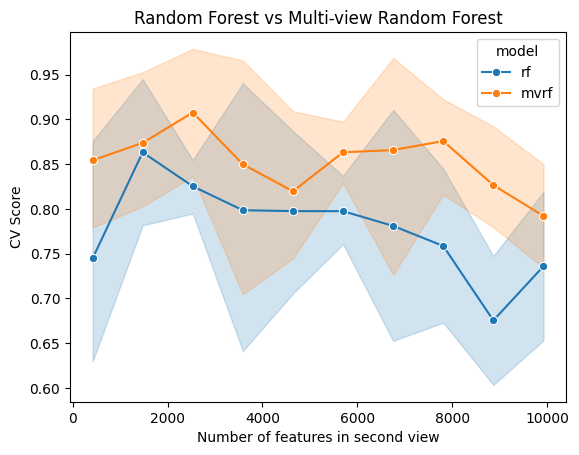

In [281]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

# [Monotonic decreasing exp] Repeat experiment to show monotonically decreasing performance gap of RF

In the previous setup, we sampled a completely new dataset and increased the number of noise dimensions in the second view and repeated this each time to
generate a confidence interval.

However, this is somewhat of a noisy experiment.

Instead, what we will do is first construct the signal dataset, and keep that fixed, and then add varying degrees of noise.

## Confounder Y <- X1 -> X2

In [1]:
n_features = 10
noise_dims = 90

In [2]:
n_repeats = 100
n_estimators = 500

In [3]:
n_features_2_list = np.linspace(800, 10_000 - 200, 10, dtype=int)
n_features_2_list = np.insert(n_features_2_list, 0, 0)
print(n_features_2_list)

NameError: name 'np' is not defined

In [4]:
results = defaultdict(list)

for idx in range(n_repeats):
    n_features_begin = 0
    fixed_center = rng.standard_normal(size=(n_features,))
    # centers = [
    #     rng.standard_normal(size=(n_features,)),
    #     rng.standard_normal(size=(n_features,)),
    # ]
    centers = [fixed_center, fixed_center]

    covariances = [
        make_spd_matrix(n_dim=n_features, random_state=seed),
        make_spd_matrix(n_dim=n_features, random_state=seed + 123),
    ]

    Xs, y = make_gaussian_mixture(
        centers,
        covariances,
        n_samples=n_samples,
        noise=1.0,
        noise_dims=noise_dims,
        shuffle=True,
        class_probs=class_probs,
        random_state=seed + idx,
    )

    signal_X = np.hstack((Xs[1], Xs[0]))
    # print(signal_X.shape, y.shape)
    n_features_ends = [
        n_features + noise_dims,
        n_features_2 + n_features + noise_dims * 2,
    ]
    # print(n_features_ends)

    for n_features_2_ in n_features_2_list:
        _X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, n_features_2_))))
        X = _X.copy()
        n_features_ends[1] = X.shape[1]
        # print(X.shape, _X.shape)

        # print(
        #     "New dataset: ",
        #     n_features_2_,
        #     n_features_ends,
        #     X.shape,
        #     y.shape,
        #     n_features_begin,
        # )

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)
    # break

NameError: name 'defaultdict' is not defined

In [87]:
df = pd.DataFrame(results)

In [88]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features_2", "noise_dims", "n_samples"],
    var_name="model",
    value_name="score",
)

In [89]:
display(df.head())

,n_features_2,noise_dims,n_samples,model,score
0,0,80,500,rf,0.786667
1,800,80,500,rf,0.671579
2,1800,80,500,rf,0.640702
3,2800,80,500,rf,0.653333
4,3800,80,500,rf,0.625263


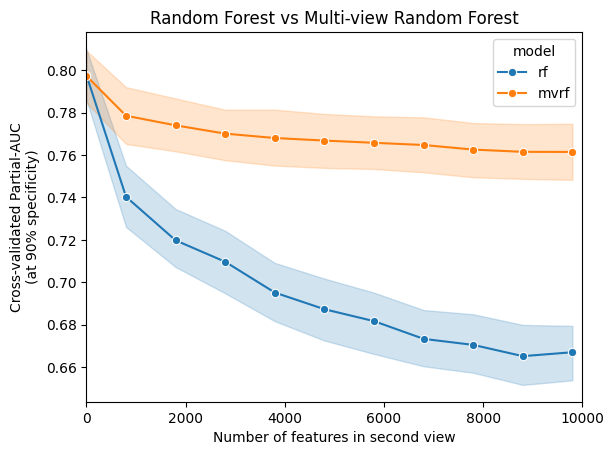

In [90]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("Cross-validated Partial-AUC\n(at 90% specificity)")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
ax.set(
    xlim=[0, 10_000],
)
plt.show()

In [92]:
# save the results
df.to_csv("./cv_partial_auc_mv_vs_rf_linear_transform.csv")

## Independent views with X2 being d-separated (X1 -> Y; X2)

In [7]:
n_features_1 = 20
n_features_2 = 20
noise_dims = 80
n_estimators = 500
n_repeats = 100

In [8]:
n_features_2_list = np.linspace(900, 10_000 - 100, 11, dtype=int)
n_features_2_list = np.insert(n_features_2_list, 0, 100)
print(n_features_2_list)
print(n_repeats)

[ 100  900 1800 2700 3600 4500 5400 6300 7200 8100 9000 9900]
100


In [14]:
results = defaultdict(list)

for idx in range(n_repeats):
    signal_X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features_1 + noise_dims,
        n_informative=n_features_1,
        n_redundant=10,
        n_repeated=0,
        n_classes=2,
        class_sep=2.0,
        flip_y=0.01,
        shuffle=False,
        random_state=seed + idx,
    )
    n_features_ends = [n_features_1 + noise_dims, signal_X.shape[1]]

    for n_features_2_ in n_features_2_list:
        _X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, n_features_2_))))
        X = _X.copy()
        n_features_ends[1] = X.shape[1]

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

In [15]:
print(n_features_ends)

[100, 10000]


In [16]:
df = pd.DataFrame(results)

In [17]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features_2", "noise_dims", "n_samples"],
    var_name="model",
    value_name="score",
)

In [18]:
display(df.head())

,n_features_2,noise_dims,n_samples,model,score
0,100,80,500,rf,0.966316
1,900,80,500,rf,0.955789
2,1800,80,500,rf,0.962105
3,2700,80,500,rf,0.960000
4,3600,80,500,rf,0.953684


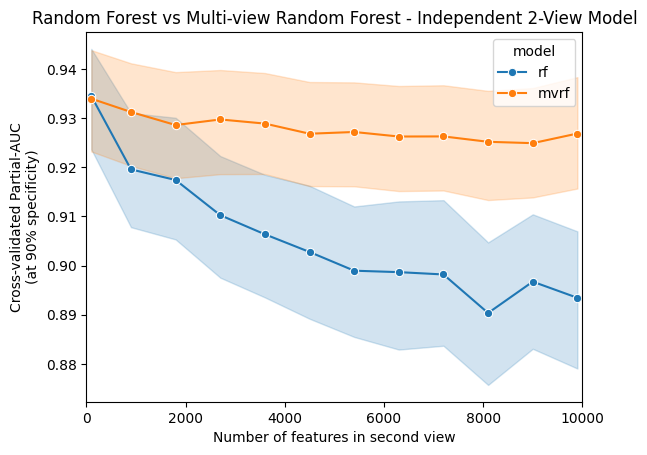

In [19]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("Cross-validated Partial-AUC\n(at 90% specificity)")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest - Independent 2-View Model")
ax.set(
    xlim=[0, 10_000],
)
plt.show()

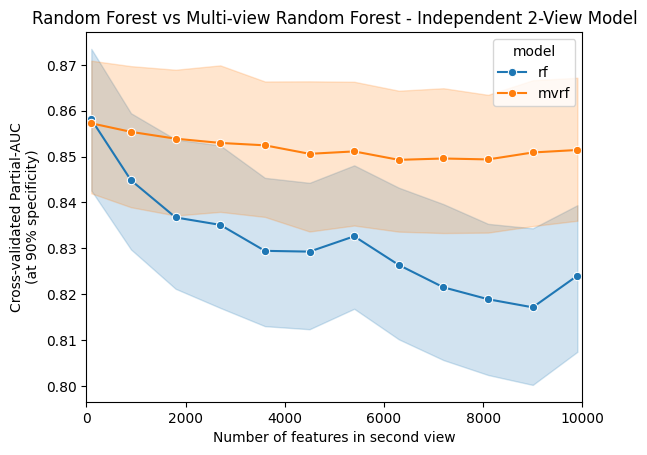

In [129]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("Cross-validated Partial-AUC\n(at 90% specificity)")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest - Independent 2-View Model")
ax.set(
    xlim=[0, 10_000],
)
plt.show()

In [20]:
# save the results
df.to_csv("./cv_partial_auc_mv_vs_rf_ind_views_gaussian_mixture_v2.csv")

In [34]:
n_views = 2
n_features = 100
n_samples = 500
joint_rank = 2

In [35]:
n_features_2_list = np.linspace(800, 10_000 - 200, 10, dtype=int)
n_features_2_list = np.insert(n_features_2_list, 0, 0)
print(n_features_2_list)
print(n_repeats)

[   0  800 1800 2800 3800 4800 5800 6800 7800 8800 9800]
100


In [37]:
results = defaultdict(list)

for idx in range(n_repeats):
    Xs = make_joint_factor_model(
        n_views,
        n_features,
        n_samples=n_samples,
        joint_rank=joint_rank,
        noise_std=1,
        m=1.5,
        random_state=seed + idx,
        return_decomp=False,
    )
    n_features_1 = Xs[0].shape[1]
    n_features_2 = Xs[1].shape[1]
    signal_X = np.hstack(Xs)

    print(signal_X.shape, n_features_1, n_features_2, [x.shape for x in Xs])
    y = rng.binomial(
        n=1, p=expit(Xs[0][:, :10].sum(axis=1)), size=n_samples
    ) * rng.binomial(n=1, p=expit(Xs[1][:, :10].sum(axis=1)), size=n_samples)

    n_features_ends = [n_features_1 + noise_dims, signal_X.shape[1]]

    for n_features_2_ in n_features_2_list:
        _X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, n_features_2_))))
        X = _X.copy()
        n_features_ends[1] = X.shape[1]

        print(X.shape)
        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

(500, 200) 100 100 [(500, 100), (500, 100)]
(500, 200)
(500, 1000)
(500, 2000)
(500, 3000)
(500, 4000)
(500, 5000)
(500, 6000)
(500, 7000)
(500, 8000)
(500, 9000)
(500, 10000)
(500, 200) 100 100 [(500, 100), (500, 100)]
(500, 200)
(500, 1000)
(500, 2000)
(500, 3000)
(500, 4000)
(500, 5000)
(500, 6000)
(500, 7000)
(500, 8000)
(500, 9000)
(500, 10000)
(500, 200) 100 100 [(500, 100), (500, 100)]
(500, 200)
(500, 1000)
(500, 2000)
(500, 3000)
(500, 4000)
(500, 5000)
(500, 6000)
(500, 7000)
(500, 8000)
(500, 9000)
(500, 10000)
(500, 200) 100 100 [(500, 100), (500, 100)]
(500, 200)
(500, 1000)
(500, 2000)
(500, 3000)
(500, 4000)
(500, 5000)
(500, 6000)
(500, 7000)
(500, 8000)
(500, 9000)
(500, 10000)
(500, 200) 100 100 [(500, 100), (500, 100)]
(500, 200)
(500, 1000)
(500, 2000)
(500, 3000)
(500, 4000)
(500, 5000)
(500, 6000)
(500, 7000)
(500, 8000)
(500, 9000)
(500, 10000)
(500, 200) 100 100 [(500, 100), (500, 100)]
(500, 200)
(500, 1000)
(500, 2000)
(500, 3000)
(500, 4000)
(500, 5000)
(500,

In [38]:
df = pd.DataFrame(results)

In [39]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features_2", "noise_dims", "n_samples"],
    var_name="model",
    value_name="score",
)

In [40]:
display(df.head())

,n_features_2,noise_dims,n_samples,model,score
0,0,80,500,rf,0.701995
1,800,80,500,rf,0.571684
2,1800,80,500,rf,0.590109
3,2800,80,500,rf,0.572485
4,3800,80,500,rf,0.503592


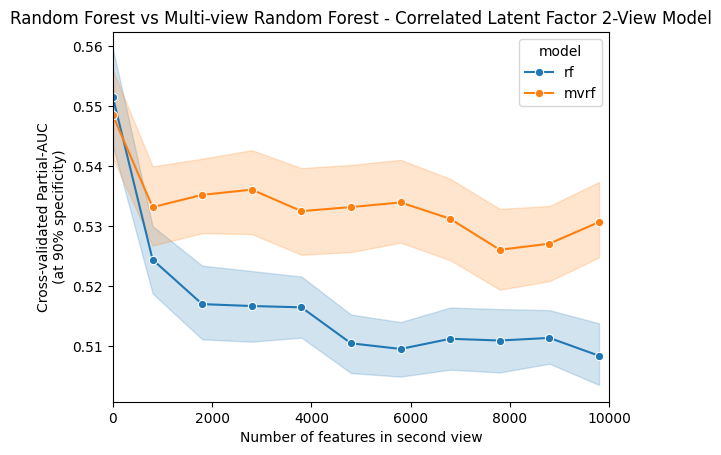

In [41]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("Cross-validated Partial-AUC\n(at 90% specificity)")
ax.set_xlabel("Number of features in second view")
ax.set_title(
    "Random Forest vs Multi-view Random Forest - Correlated Latent Factor 2-View Model"
)
ax.set(
    xlim=[0, 10_000],
)
plt.show()

In [42]:
# save the results
df.to_csv("./cv_partial_auc_mv_vs_rf_correlated_latentfactor_model.csv")

In [43]:
print("done")

done


## Collider Independent views with both views providing information (X1 -> Y <- X2)

In [118]:
n_features_1 = 10
n_features_2 = 10
noise_dims = 90
n_estimators = 500
n_repeats = 100
max_features = "sqrt"

cluster_std_first = 5.0
cluster_std_second = 1.0

In [119]:
n_features_2_list = np.linspace(800, 10_000 - 200, 10, dtype=int)
n_features_2_list = np.insert(n_features_2_list, 0, 0)
print(n_features_2_list)
print(n_repeats)

[   0  800 1800 2800 3800 4800 5800 6800 7800 8800 9800]
100


In [126]:
results = defaultdict(list)

for idx in range(n_repeats):
    # Create a high-dimensional multiview dataset with a low-dimensional informative
    # subspace in one view of the dataset.
    # X0_first, y0 = make_blobs(
    #     n_samples=n_samples,
    #     cluster_std=cluster_std_first,
    #     n_features=n_features_1,
    #     center_box=(2.5, 7.5),
    #     random_state=seed,
    #     centers=1,
    # )

    # X1_first, y1 = make_blobs(
    #     n_samples=n_samples,
    #     cluster_std=cluster_std_second,
    #     n_features=n_features_2,
    #     center_box=(-5, 5),
    #     random_state=seed + 1,
    #     centers=1,
    # )
    # X0 = np.concatenate(
    #     [X0_first, rng.standard_normal(size=(n_samples, noise_dims))], axis=1
    # )
    # X1 = np.concatenate(
    #     [X1_first, rng.standard_normal(size=(n_samples, noise_dims))], axis=1
    # )

    # signal_X = np.hstack((X0, X1))
    # y = expit(X0_first[:, :n_features_1//2] + X1_first[:, :n_features_1//2]
    # y = rng.binomial(
    #     n=1, p=expit(X0_first[:, :10].sum(axis=1)), size=n_samples
    # ) * rng.binomial(n=1, p=expit(X1_first[:, :10].sum(axis=1)), size=n_samples)

    signal_X_1, y1 = make_classification(
        n_samples=n_samples,
        n_features=n_features_1 + noise_dims,
        n_informative=n_features_1,
        n_redundant=10,
        n_repeated=0,
        n_classes=2,
        class_sep=1.0,
        flip_y=0.02,
        shuffle=False,
        random_state=seed + idx,
    )
    signal_X_2, y2 = make_classification(
        n_samples=n_samples,
        n_features=n_features_1 + noise_dims,
        n_informative=n_features_1,
        n_redundant=10,
        n_repeated=0,
        n_classes=2,
        class_sep=0.75,
        flip_y=0.02,
        shuffle=False,
        random_state=seed + idx + idx,
    )
    signal_X = np.hstack((signal_X_1, signal_X_2))
    y = y1.copy()

    keep_inds = np.argwhere(y1 == y2)
    y = y[keep_inds, ...]
    y2 = y2[keep_inds, ...].squeeze()
    signal_X = signal_X[keep_inds, ...].squeeze()

    np.testing.assert_array_equal(y.squeeze(), y2)

    n_features_ends = [n_features_1 + noise_dims, signal_X.shape[1]]
    print(signal_X.shape, y.shape, n_features_ends)

    for n_features_2_ in n_features_2_list:
        _X = np.hstack(
            (signal_X, rng.standard_normal(size=(signal_X.shape[0], n_features_2_)))
        )
        X = _X.copy()
        n_features_ends[1] = X.shape[1]
        print(X.shape, y.shape, n_features_ends)

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

(500, 200) (500, 1) [100, 200]
(500, 200) (500, 1) [100, 200]
(500, 1000) (500, 1) [100, 1000]
(500, 2000) (500, 1) [100, 2000]
(500, 3000) (500, 1) [100, 3000]
(500, 4000) (500, 1) [100, 4000]
(500, 5000) (500, 1) [100, 5000]
(500, 6000) (500, 1) [100, 6000]
(500, 7000) (500, 1) [100, 7000]
(500, 8000) (500, 1) [100, 8000]
(500, 9000) (500, 1) [100, 9000]
(500, 10000) (500, 1) [100, 10000]
(482, 200) (482, 1) [100, 200]
(482, 200) (482, 1) [100, 200]
(482, 1000) (482, 1) [100, 1000]
(482, 2000) (482, 1) [100, 2000]
(482, 3000) (482, 1) [100, 3000]
(482, 4000) (482, 1) [100, 4000]
(482, 5000) (482, 1) [100, 5000]
(482, 6000) (482, 1) [100, 6000]
(482, 7000) (482, 1) [100, 7000]
(482, 8000) (482, 1) [100, 8000]
(482, 9000) (482, 1) [100, 9000]
(482, 10000) (482, 1) [100, 10000]
(486, 200) (486, 1) [100, 200]
(486, 200) (486, 1) [100, 200]
(486, 1000) (486, 1) [100, 1000]
(486, 2000) (486, 1) [100, 2000]
(486, 3000) (486, 1) [100, 3000]
(486, 4000) (486, 1) [100, 4000]
(486, 5000) (486, 

In [127]:
df = pd.DataFrame(results)

In [128]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features_2", "noise_dims", "n_samples"],
    var_name="model",
    value_name="score",
)

In [129]:
display(df.head())

,n_features_2,noise_dims,n_samples,model,score
0,0,90,500,rf,0.850526
1,800,90,500,rf,0.772632
2,1800,90,500,rf,0.760000
3,2800,90,500,rf,0.791579
4,3800,90,500,rf,0.701053


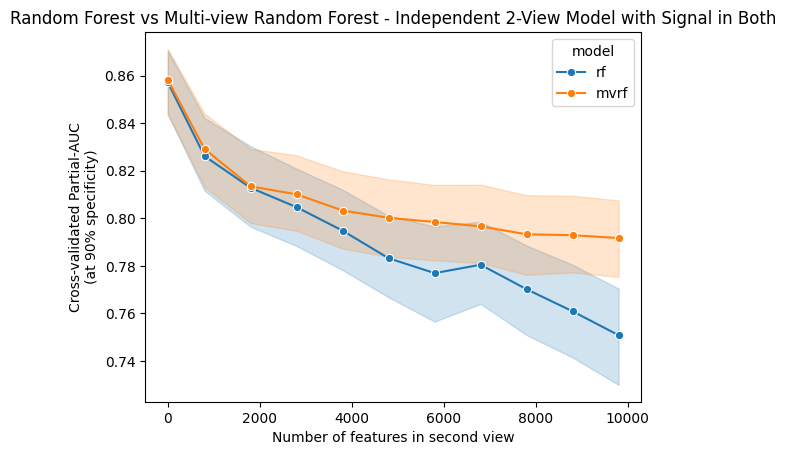

In [130]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("Cross-validated Partial-AUC\n(at 90% specificity)")
ax.set_xlabel("Number of features in second view")
ax.set_title(
    "Random Forest vs Multi-view Random Forest - Independent 2-View Model with Signal in Both"
)
# ax.set(
#     xlim=[0, 10_000],
# )
plt.show()

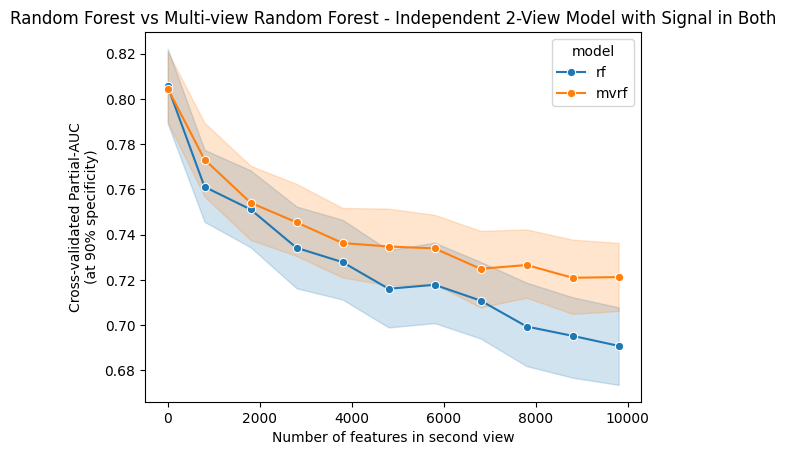

In [124]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("Cross-validated Partial-AUC\n(at 90% specificity)")
ax.set_xlabel("Number of features in second view")
ax.set_title(
    "Random Forest vs Multi-view Random Forest - Independent 2-View Model with Signal in Both"
)
# ax.set(
#     xlim=[0, 10_000],
# )
plt.show()

In [125]:
# save the results
df.to_csv("./cv_partial_auc_mv_vs_rf_collider_at_y_gaussian_mixture.csv")

In [131]:
print("done")

done


## Mediator (X1 -> X2 -> Y)


In [74]:
n_features = 10
noise_dims = 90
n_samples = 500
n_estimators = 500
n_repeats = 5
max_features = 0.3

n_views = 1
joint_rank = 5

In [75]:
n_features_2_list = np.linspace(900, 10_000 - 100, 10, dtype=int)
n_features_2_list = np.insert(n_features_2_list, 0, n_features + noise_dims)
print(n_features_2_list)
print(n_repeats)

[ 100  900 1900 2900 3900 4900 5900 6900 7900 8900 9900]
5


In [76]:
results = defaultdict(list)

for idx in range(n_repeats):
    Xs, U, _ = make_joint_factor_model(
        n_views,
        n_features,
        n_samples=n_samples,
        joint_rank=joint_rank,
        noise_std=10.0,
        m=0.25,
        random_state=seed + idx,
        return_decomp=True,
    )

    signal_X = np.hstack(Xs)
    signal_X += rng.standard_normal(size=signal_X.shape)
    signal_X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, noise_dims))))
    n_features_1 = signal_X.shape[1]
    print(signal_X.shape)
    y = rng.binomial(n=1, p=expit(signal_X[:, :n_features].sum(axis=1)), size=n_samples)

    U += rng.standard_normal(size=U.shape)  # * 2.0
    U = np.hstack(
        (U, rng.standard_normal(size=(signal_X.shape[0], n_features_1 - joint_rank)))
    )

    n_features_ends = [n_features_1, signal_X.shape[1]]
    # print(n_features_ends)
    print(U.shape, signal_X.shape, y.shape, [x.shape for x in Xs])

    for n_features_2_ in n_features_2_list[5:]:
        _X = np.hstack(
            (
                U,
                signal_X,
                rng.standard_normal(
                    size=(signal_X.shape[0], n_features_2_ - signal_X.shape[1])
                ),
            )
        )
        X = _X.copy()
        print(X.shape)

        n_features_ends[1] = X.shape[1]
        print(n_features_ends)
        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

(500, 100)
(500, 100) (500, 100) (500,) [(500, 10)]
(500, 5000)
[100, 5000]
(500, 6000)
[100, 6000]
(500, 7000)
[100, 7000]
(500, 8000)
[100, 8000]
(500, 9000)
[100, 9000]
(500, 10000)
[100, 10000]
(500, 100)
(500, 100) (500, 100) (500,) [(500, 10)]
(500, 5000)
[100, 5000]
(500, 6000)
[100, 6000]
(500, 7000)
[100, 7000]
(500, 8000)
[100, 8000]
(500, 9000)
[100, 9000]
(500, 10000)
[100, 10000]
(500, 100)
(500, 100) (500, 100) (500,) [(500, 10)]
(500, 5000)
[100, 5000]
(500, 6000)
[100, 6000]
(500, 7000)
[100, 7000]
(500, 8000)
[100, 8000]
(500, 9000)
[100, 9000]
(500, 10000)
[100, 10000]
(500, 100)
(500, 100) (500, 100) (500,) [(500, 10)]
(500, 5000)
[100, 5000]
(500, 6000)
[100, 6000]
(500, 7000)
[100, 7000]
(500, 8000)
[100, 8000]
(500, 9000)
[100, 9000]
(500, 10000)
[100, 10000]
(500, 100)
(500, 100) (500, 100) (500,) [(500, 10)]
(500, 5000)
[100, 5000]
(500, 6000)
[100, 6000]
(500, 7000)
[100, 7000]
(500, 8000)
[100, 8000]
(500, 9000)
[100, 9000]
(500, 10000)
[100, 10000]


In [77]:
df = pd.DataFrame(results)

In [78]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features_2", "noise_dims", "n_samples"],
    var_name="model",
    value_name="score",
)

In [79]:
display(df.head())

,n_features_2,noise_dims,n_samples,model,score
0,4900,90,500,rf,0.673684
1,5900,90,500,rf,0.677895
2,6900,90,500,rf,0.663158
3,7900,90,500,rf,0.669474
4,8900,90,500,rf,0.709474


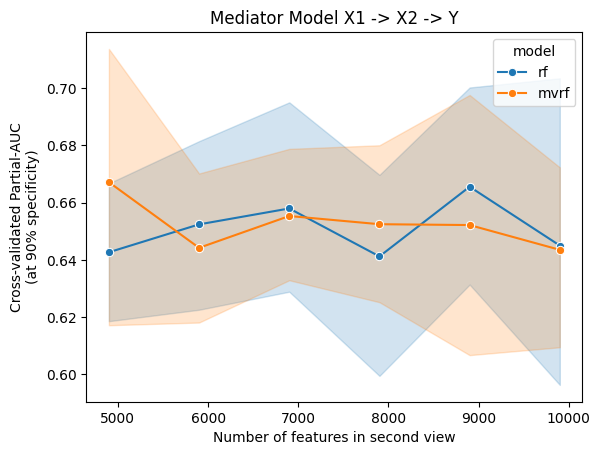

In [80]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("Cross-validated Partial-AUC\n(at 90% specificity)")
ax.set_xlabel("Number of features in second view")
ax.set_title("Mediator Model X1 -> X2 -> Y")
# ax.set(
#     xlim=[0, 10_000],
# )
plt.show()

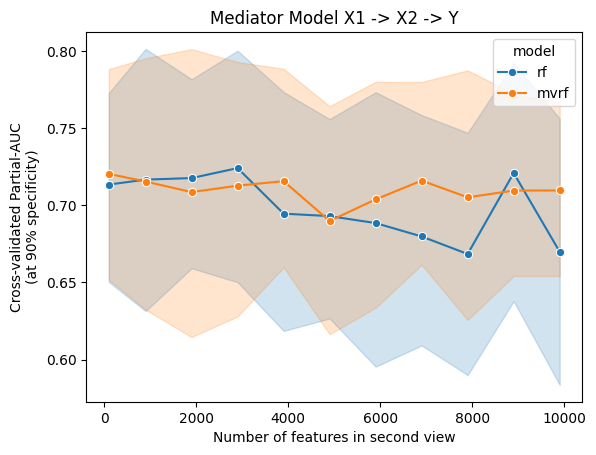

In [76]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("Cross-validated Partial-AUC\n(at 90% specificity)")
ax.set_xlabel("Number of features in second view")
ax.set_title("Mediator Model X1 -> X2 -> Y")
# ax.set(
#     xlim=[0, 10_000],
# )
plt.show()

In [125]:
# save the results
df.to_csv("./cv_partial_auc_mv_vs_rf_mediator_gaussian_mixture.csv")

In [131]:
print("done")

done


## Direct/Indirect Effects (X1 -> X2 -> Y; X1 -> Y)

In [61]:
print(0.3 * 100, 0.3 * 200)

30.0 60.0


In [70]:
n_features = 10
noise_dims = 90
n_samples = 500
n_estimators = 500
n_repeats = 2
max_features = 0.3

n_views = 1
joint_rank = 5

In [71]:
n_features_2_list = np.linspace(900, 10_000 - 100, 10, dtype=int)
n_features_2_list = np.insert(n_features_2_list, 0, n_features + noise_dims)
print(n_features_2_list)
print(n_repeats)

[ 100  900 1900 2900 3900 4900 5900 6900 7900 8900 9900]
2


In [72]:
print(U.shape)

(500, 100)


In [73]:
results = defaultdict(list)

for idx in range(n_repeats):

    Xs, U, _ = make_joint_factor_model(
        n_views,
        n_features,
        n_samples=n_samples,
        joint_rank=joint_rank,
        noise_std=10.0,
        m=1.0,
        random_state=seed + idx,
        return_decomp=True,
    )
    signal_X = Xs[0]
    signal_X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, noise_dims))))
    n_features_1 = signal_X.shape[1]
    print(signal_X.shape)
    y = rng.binomial(n=1, p=expit(Xs[0][:, :10].sum(axis=1)), size=n_samples)

    U = np.hstack(
        (U, rng.standard_normal(size=(signal_X.shape[0], n_features_1 - joint_rank)))
    )

    n_features_ends = [n_features_1, signal_X.shape[1]]
    # print(n_features_ends)
    print(U.shape, signal_X.shape, y.shape, [x.shape for x in Xs])

    for n_features_2_ in n_features_2_list[5:]:
        _X = np.hstack(
            (
                # Xs[1],
                U,
                rng.standard_normal(
                    size=(signal_X.shape[0], n_features_2_ - U.shape[1])
                ),
            )
        )
        X = _X.copy()
        print(X.shape, n_features_ends)

        n_features_ends[1] = X.shape[1]
        print(n_features_ends)
        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

(500, 100)
(500, 100) (500, 100) (500,) [(500, 10)]
(500, 4900) [100, 100]
[100, 4900]
(500, 5900) [100, 4900]
[100, 5900]
(500, 6900) [100, 5900]
[100, 6900]
(500, 7900) [100, 6900]
[100, 7900]
(500, 8900) [100, 7900]
[100, 8900]
(500, 9900) [100, 8900]
[100, 9900]
(500, 100)
(500, 100) (500, 100) (500,) [(500, 10)]
(500, 4900) [100, 100]
[100, 4900]
(500, 5900) [100, 4900]
[100, 5900]
(500, 6900) [100, 5900]
[100, 6900]
(500, 7900) [100, 6900]
[100, 7900]
(500, 8900) [100, 7900]
[100, 8900]
(500, 9900) [100, 8900]
[100, 9900]


In [74]:
df = pd.DataFrame(results)

In [75]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features_2", "noise_dims", "n_samples"],
    var_name="model",
    value_name="score",
)

In [76]:
display(df.head())

,n_features_2,noise_dims,n_samples,model,score
0,4900,90,500,rf,0.661775
1,5900,90,500,rf,0.610746
2,6900,90,500,rf,0.640688
3,7900,90,500,rf,0.610324
4,8900,90,500,rf,0.620867


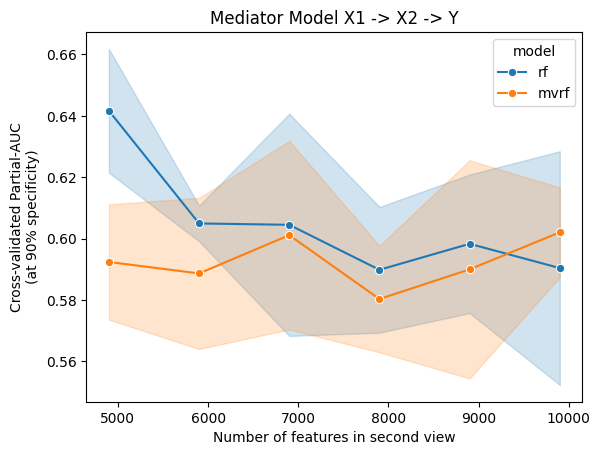

In [77]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("Cross-validated Partial-AUC\n(at 90% specificity)")
ax.set_xlabel("Number of features in second view")
ax.set_title("Mediator Model X1 -> X2 -> Y")
# ax.set(
#     xlim=[0, 10_000],
# )
plt.show()

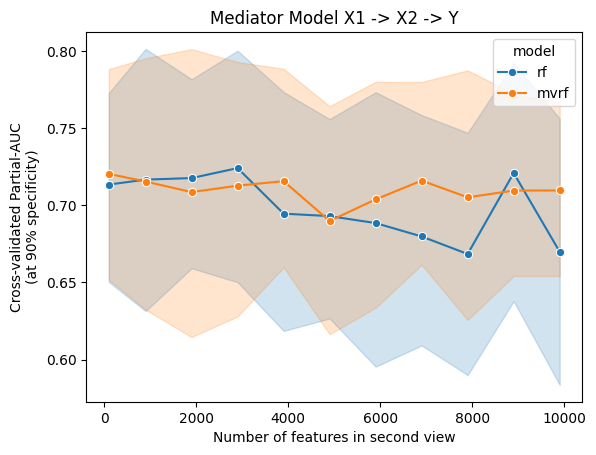

In [76]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("Cross-validated Partial-AUC\n(at 90% specificity)")
ax.set_xlabel("Number of features in second view")
ax.set_title("Mediator Model X1 -> X2 -> Y")
# ax.set(
#     xlim=[0, 10_000],
# )
plt.show()

In [125]:
# save the results
df.to_csv("./cv_partial_auc_mv_vs_rf_collider_at_y_gaussian_mixture.csv")

In [131]:
print("done")

done


# Adjusting for Latent confounding

## Correlated views via a latent factor X1 -> Y